In [3]:
# import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
import os
import gc
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from datasets.SegDataset import SegmentationDataset
from models import *
from torchvision.models import resnet18, resnet50, ResNet18_Weights, ResNet50_Weights
from models import SwinB_UNet

# Load and prep data

Using Apple Metal Performance Shaders (MPS) device.
[[[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.04701703]
  [0.04497263]
  [0.04607238]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.04760202]
  [0.04718105]
  [0.0453882 ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.04948078]
  [0.04880713]
  [0.04513949]]

 ...

 [[0.04631588]
  [0.04799692]
  [0.04976858]
  ...
  [0.05189315]
  [0.05210353]
  [0.0484738 ]]

 [[0.04623747]
  [0.0486441 ]
  [0.04871247]
  ...
  [0.04980389]
  [0.05027085]
  [0.05165437]]

 [[0.04706882]
  [0.049333  ]
  [0.04664364]
  ...
  [0.04962937]
  [0.04844106]
  [0.04813458]]]
Image shape: (128, 128, 9)


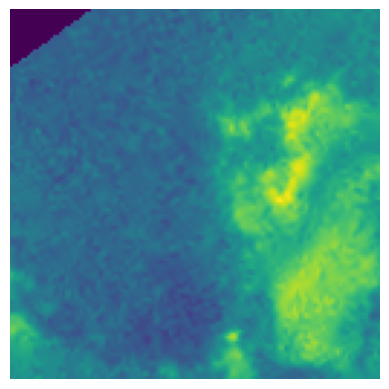

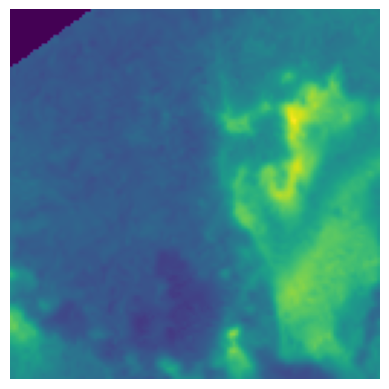

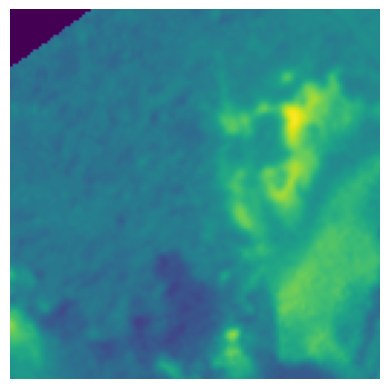

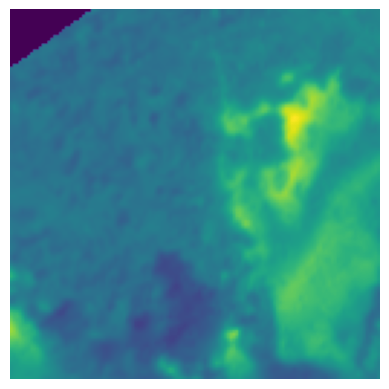

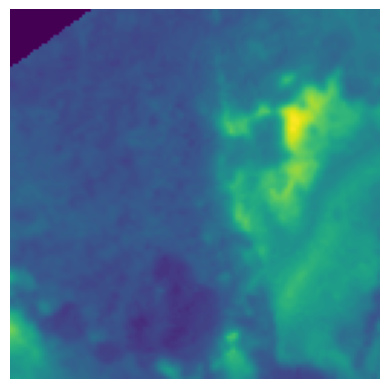

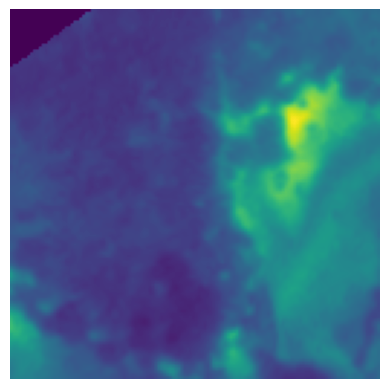

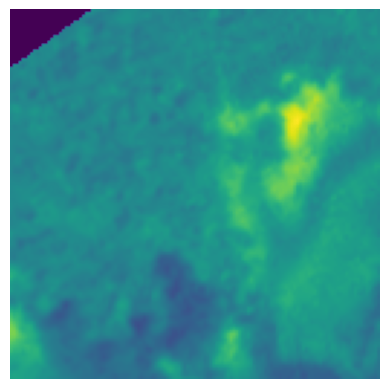

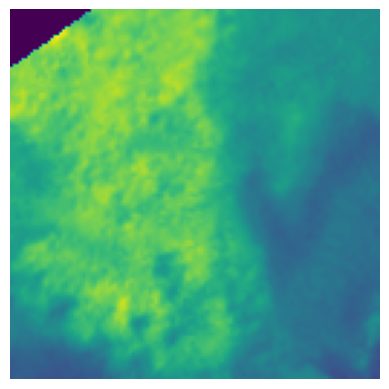

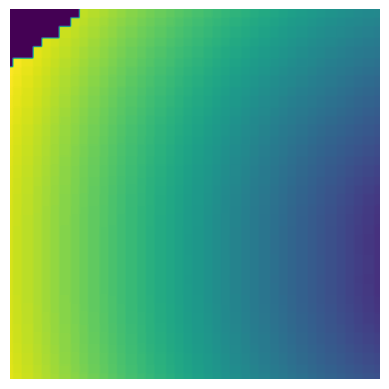

[INFO] found 3478 examples in the training set...
[INFO] found 614 examples in the test set...


6484

In [4]:
TEST_SPLIT = 0.15
NUM_CHANNELS = 9
NUM_CLASSES = 1
INIT_LR = 0.001
NUM_EPOCHS = 30
BATCH_SIZE = 64
INPUT_IMAGE_SIZE = 128
THRESHOLD = 0.5
# define the path to the base output directory
BASE_OUTPUT = "output"

# Pull data from data folder
cwd = os.getcwd()
with open(cwd + '/data/128px_images.pkl', 'rb') as handle:
    images = pickle.load(handle)
with open(cwd + '/data/128px_labels.pkl', 'rb') as handle:
    labels = pickle.load(handle)
with open(cwd + '/data/128_mlabels.pkl', 'rb') as handle:
    m_tiles = pickle.load(handle)

# Setup the device to be used for training and evaluation
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    x = torch.ones(1, device=DEVICE)
    print("Using CUDA device.")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    x = torch.ones(1, device=DEVICE)
    print("Using Apple Metal Performance Shaders (MPS) device.")
else:
    DEVICE = torch.device("cpu")
    print("No GPU found. Defaulting to CPU.")

# partition the data into training and testing splits 
# uses 85% of the data for training and the remaining 15% for testing
trainImages, testImages, trainMasks, testMasks = train_test_split(images, labels,
                         test_size=TEST_SPLIT, random_state=42)
image = trainImages[3000]

rgb = image[:, :, :3]
print(rgb[:,:,:1])


print(f"Image shape: {image.shape}")
for channel in range(9):
    plt.imshow(image[:, :, channel])
    plt.axis('off')  # To hide axis
    plt.show()

# NOTE: we are not using transforms, because there are too many channels for standard PIL transforms
trainDS = SegmentationDataset(images=trainImages, labels=trainMasks)                            
testDS = SegmentationDataset(images=testImages, labels=testMasks)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")

# calculate steps per epoch for training and test set #config
TRAIN_STEPS = len(trainDS) // BATCH_SIZE
TEST_STEPS = len(testDS) // BATCH_SIZE

# create the training and test data loaders #config
trainLoader = DataLoader(trainDS, shuffle=True,
                         batch_size=BATCH_SIZE,
                         num_workers=0)
testLoader = DataLoader(testDS, shuffle=False,
                        batch_size=BATCH_SIZE,
                        num_workers=0)


del trainImages, testImages, trainMasks, testMasks, trainDS, testDS
gc.collect()

# Training Pipeline

In [5]:
def evaluate(model: nn.Module, dataloader: DataLoader, loss_func):
    model.eval()
    total_loss = 0
    total_TP = 0
    total_FP = 0
    total_FN = 0
    total_TN = 0

    with torch.no_grad():
        for (x, y) in dataloader:
            x = x.permute(0, 3, 1, 2).to(DEVICE)
            y = y.permute(0, 3, 1, 2).to(DEVICE)
            y = y.float()
            
            pred = model(x)
            if isinstance(pred, tuple):
                pred = pred[0]
            loss = loss_func(pred, y)
            total_loss += loss.item()

            pred = torch.sigmoid(pred).view(-1)
            y = y.view(-1)
            
            TP = (pred * y).sum().item()
            FP = ((1 - y) * pred).sum().item()
            FN = (y * (1 - pred)).sum().item()
            TN = ((1 - y) * (1 - pred)).sum().item()

            total_TP += TP
            total_FP += FP
            total_FN += FN
            total_TN += TN

    avg_loss = total_loss / len(dataloader)
    precision = total_TP / (total_TP + total_FP) if (total_TP + total_FP) > 0 else 0
    recall = total_TP / (total_TP + total_FN) if (total_TP + total_FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    iou = total_TP / (total_TP + total_FP + total_FN) if (total_TP + total_FP + total_FN) > 0 else 0
    accuracy = (total_TP + total_TN) / (total_TP + total_FP + total_FN + total_TN) if (total_TP + total_FP + total_FN + total_TN) > 0 else 0
    specificity = total_TN / (total_TN + total_FP) if (total_TN + total_FP) > 0 else 0

    metrics = {
        'Loss': avg_loss,
        'Precision': precision,
        'Recall': recall,
        'f1_score': f1_score,
        'IOU': iou,
        'Accuracy': accuracy,
        'Specificity': specificity
    }

    return metrics


In [6]:
def train(model, trainLoader : DataLoader, testLoader : DataLoader, lossFunc, print_all_epochs = False):
  opt = Adam(model.parameters(), lr=INIT_LR)
  # loop over epochs #config
  print("[INFO] training the network...")
  training_loss = []
  all_metrics = []

  for e in tqdm(range(NUM_EPOCHS)):
    # set the model in training mode
    model.train()
    totalTrainLoss = 0

    # loop over the training set
    for (i, (x, y)) in enumerate(trainLoader):
      # send the input to the device
      x = x.permute(0, 3, 1, 2).to(DEVICE)
      y = y.permute(0, 3, 1, 2).to(DEVICE)
      y = y.float()

      # perform a forward pass and calculate the training loss
      pred = model(x)
      if isinstance(pred, tuple):
        pred = pred[0]
      loss = lossFunc(pred, y)

      # first, zero out any previously accumulated gradients, then
      # perform backpropagation, and then update model parameters
      opt.zero_grad()
      loss.backward()
      opt.step()

      # add the loss to the total training loss so far
      totalTrainLoss += loss.item()
    # calculate the average training
    avgTrainLoss = totalTrainLoss / TRAIN_STEPS
    training_loss.append(avgTrainLoss)

    # Evaluate on test dataset
    metrics = evaluate(model, testLoader, lossFunc)
    all_metrics.append(metrics)
    avgTestLoss = metrics['Loss']

    if (e + 1) % 5 == 0 or e == 0 or print_all_epochs:
      # print the model training and validation information
      print("EPOCH: {}/{}".format(e + 1, NUM_EPOCHS)) #config
      print("Train loss: {:.6f}, Test loss: {:.4f}".format(
          avgTrainLoss, avgTestLoss))
      print("\nValidation Metrics:")
      for k, v in metrics.items():
          if k != 'Loss':
            print(f"{k}: {v}")
      print("\n")
  return training_loss, all_metrics

In [16]:
def plot_losses(title, training_loss, validation_loss, training_time=None, y_max=0.3):
  # scale losses to fit graph
  valid_loss = [min(x,y_max) for x in validation_loss]
  train_loss = [min(x, y_max) for x in training_loss]


  plt.figure()
  plt.plot(np.arange(1, NUM_EPOCHS+1), train_loss, label="train_loss")
  plt.plot(np.arange(1, NUM_EPOCHS+1), valid_loss, label="valid_loss")
  plt.title(title)
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc="upper right")
  if training_time is not None:
    plt.text(0, 0.3, f"Training Time: {training_time}")


  yticks = np.arange(0.025, 0.325, 0.025)  # Generate ticks from 0.025 to 0.3 with step 0.025
  plt.yticks(yticks)

  xticks = np.arange(2, NUM_EPOCHS+2, 2)  # Generate ticks from 0 to num_epochs with step 2
  plt.xticks(xticks)
  
  plt.show()

def plot_metrics(title: str, metric_dict: dict, metrics: list = ['Precision', 'Recall', 'IOU']):
    plt.figure()
    for metric in metrics:
        plt.plot(np.arange(0, NUM_EPOCHS), [x[metric] for x in metric_dict], label=metric)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.legend(loc="lower right")

    yticks = np.arange(0.0, 1.1, 0.1)
    plt.yticks(yticks)

    xticks = np.arange(2, NUM_EPOCHS+2, 2)
    plt.xticks(xticks)
    
    plt.show()

def plot_loss_comparison(title, training_losses1, training_losses2, validation_losses1, validation_losses2, compare1 = "Satellite", compare2 = "ImageNet", y_max=0.3):
    # scale losses to fit graph
    valid_loss_sat = [min(x, y_max) for x in validation_losses1]
    train_loss_sat = [min(x, y_max) for x in training_losses1]
    valid_loss_img = [min(x, y_max) for x in validation_losses2]
    train_loss_img = [min(x, y_max) for x in training_losses2]
    
    plt.figure()
    plt.plot(np.arange(0, NUM_EPOCHS), train_loss_sat, label=f"Training loss {compare1}", color='orange')
    plt.plot(np.arange(0, NUM_EPOCHS), valid_loss_sat, label=f"Validation loss {compare1}", color='orange', linestyle='dashed')
    plt.plot(np.arange(0, NUM_EPOCHS), train_loss_img, label=f"Training loss {compare2}", color='teal')
    plt.plot(np.arange(0, NUM_EPOCHS), valid_loss_img, label=f"Validation loss {compare2}", color='teal', linestyle='dashed')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    
    yticks = np.arange(0.025, 0.325, 0.025)  # Generate ticks from 0.025 to 0.3 with step 0.025
    plt.yticks(yticks)
    
    xticks = np.arange(2, NUM_EPOCHS+2, 2)  # Generate ticks from 0 to num_epochs with step 2
    plt.xticks(xticks)
    
    plt.show()

def plot_comparison_metrics(title, metrics1: dict, metrics2: dict, compare1 = 'Satellite', compare2 = 'Imagenet'):
    
    metrics = ['Precision', 'Recall', 'IOU']
    list1 = [metrics1[-1][metric] for metric in metrics]
    list2 = [metrics2[-1][metric] for metric in metrics]
    
       
    
    # Create bar positions
    bar_width = 0.35
    r1 = np.arange(len(metrics))
    r2 = [x + bar_width for x in r1]
    
    # Plotting the bar chart
    plt.figure(figsize=(10, 6))
    
    plt.bar(r1, list1, color='#377eb8', width=bar_width, edgecolor='grey', label=compare1)
    plt.bar(r2, list2, color='#e41a1c', width=bar_width, edgecolor='grey', label=compare2)
    
    # Adding labels
    plt.xlabel('Metrics', fontweight='bold')
    plt.ylabel('Value', fontweight='bold')
    plt.title(title)
    plt.xticks([r + bar_width/2 for r in range(len(metrics))], metrics)
    plt.ylim(0, 1.1)
    
    plt.legend()
    plt.show()


# Model Comparisons

### Satellite ResNet18

In [10]:
# U-Net model that uses a ResNet18 backbone. 
# The ResNet is pretrained on Sentinel-2 3-channel RGB satellite imagery
weight = torch.tensor([2.0]).to(DEVICE)
loss = BCEWithLogitsLoss()

sat_resnet18_UNet_BCE = ResNet18_UNet(input_image_size=INPUT_IMAGE_SIZE).to(DEVICE)
sat_resnet18_train_BCE, sat_resnet18_metrics_BCE = train(sat_resnet18_UNet_BCE, trainLoader, testLoader, loss)
sat_resnet18_valid_BCE = [x['Loss'] for x in sat_resnet18_metrics_BCE]

[INFO] training the network...


  3%|▎         | 1/30 [00:05<02:29,  5.16s/it]

EPOCH: 1/30
Train loss: 0.321639, Test loss: 0.3544

Validation Metrics:
Precision: 0.20711206180439534
Recall: 0.14584000451225473
f1_score: 0.17115765516440895
IOU: 0.09358797692307133
Accuracy: 0.8484981888410246
Specificity: 0.932919949198485




 17%|█▋        | 5/30 [00:26<02:14,  5.37s/it]

EPOCH: 5/30
Train loss: 0.072021, Test loss: 0.0670

Validation Metrics:
Precision: 0.8443389393775785
Recall: 0.758077012608695
f1_score: 0.7988861319049472
IOU: 0.6651210623119085
Accuracy: 0.9590611155311191
Specificity: 0.9832086051418155




 33%|███▎      | 10/30 [00:50<01:36,  4.81s/it]

EPOCH: 10/30
Train loss: 0.064317, Test loss: 0.0621

Validation Metrics:
Precision: 0.8675836684789092
Recall: 0.777310542230121
f1_score: 0.8199699742205875
IOU: 0.6948721272401482
Accuracy: 0.9633893786595867
Specificity: 0.9857460565885985




 50%|█████     | 15/30 [01:15<01:13,  4.89s/it]

EPOCH: 15/30
Train loss: 0.063151, Test loss: 0.0570

Validation Metrics:
Precision: 0.8463115519702059
Recall: 0.8179426424135625
f1_score: 0.8318853086982307
IOU: 0.712160642180745
Accuracy: 0.964540663166926
Specificity: 0.982153868321671




 67%|██████▋   | 20/30 [01:39<00:48,  4.83s/it]

EPOCH: 20/30
Train loss: 0.057084, Test loss: 0.0538

Validation Metrics:
Precision: 0.8456457798896039
Recall: 0.8602343908523651
f1_score: 0.8528777047965828
IOU: 0.7434932686452088
Accuracy: 0.9681672555519161
Specificity: 0.9811349866808438




 83%|████████▎ | 25/30 [02:02<00:23,  4.61s/it]

EPOCH: 25/30
Train loss: 0.054610, Test loss: 0.0522

Validation Metrics:
Precision: 0.8724827510729949
Recall: 0.844219008450209
f1_score: 0.8581182129216528
IOU: 0.7514947892436918
Accuracy: 0.9700566634081924
Specificity: 0.9851755876636156




100%|██████████| 30/30 [02:24<00:00,  4.81s/it]

EPOCH: 30/30
Train loss: 0.052543, Test loss: 0.0504

Validation Metrics:
Precision: 0.8702346826025854
Recall: 0.837509116983798
f1_score: 0.8535583391041325
IOU: 0.7445283682705092
Accuracy: 0.9691761754851274
Specificity: 0.9849954811536867




In [9]:
loss = JaccardLoss()

sat_resnet18_UNet_jaccard = ResNet18_UNet(input_image_size=INPUT_IMAGE_SIZE).to(DEVICE)
sat_resnet18_train_jaccard, sat_resnet18_metrics_jaccard = train(sat_resnet18_UNet_jaccard, trainLoader, testLoader, loss)
sat_resnet18_valid_jaccard = [x['Loss'] for x in sat_resnet18_metrics_jaccard]

[INFO] training the network...


  3%|▎         | 1/30 [00:03<01:35,  3.28s/it]

EPOCH: 1/30
Train loss: 0.690007, Test loss: 0.9589

Validation Metrics:
Precision: 0.11046496487703017
Recall: 0.06185716727352645
f1_score: 0.0793055392825884
IOU: 0.041290033841700394
Accuracy: 0.845947917049874
Specificity: 0.9401534931629112




 17%|█▋        | 5/30 [00:14<01:12,  2.91s/it]

EPOCH: 5/30
Train loss: 0.227627, Test loss: 0.2164

Validation Metrics:
Precision: 0.8656923203492476
Recall: 0.8953731150083525
f1_score: 0.8802825993260379
IOU: 0.7861649723369419
Accuracy: 0.9738780994856863
Specificity: 0.9833101807550787




 33%|███▎      | 10/30 [00:29<01:00,  3.04s/it]

EPOCH: 10/30
Train loss: 0.205488, Test loss: 0.1986

Validation Metrics:
Precision: 0.8649367409301914
Recall: 0.9184247388057764
f1_score: 0.8908786125513273
IOU: 0.803229134910677
Accuracy: 0.9758676027564278
Specificity: 0.9827691485045174




 50%|█████     | 15/30 [00:45<00:47,  3.15s/it]

EPOCH: 15/30
Train loss: 0.193308, Test loss: 0.1908

Validation Metrics:
Precision: 0.8836475263628781
Recall: 0.9077520530860609
f1_score: 0.895537618142201
IOU: 0.8108357811479565
Accuracy: 0.9772852018269157
Specificity: 0.9856393503122315




 67%|██████▋   | 20/30 [01:02<00:32,  3.28s/it]

EPOCH: 20/30
Train loss: 0.183500, Test loss: 0.1809

Validation Metrics:
Precision: 0.8688545197438517
Recall: 0.9365092324497541
f1_score: 0.9014142201616052
IOU: 0.820522381323929
Accuracy: 0.9780281069900335
Specificity: 0.9830164447738252




 83%|████████▎ | 25/30 [01:19<00:17,  3.43s/it]

EPOCH: 25/30
Train loss: 0.178445, Test loss: 0.1765

Validation Metrics:
Precision: 0.8788440218684973
Recall: 0.9309939125569217
f1_score: 0.9041676261541859
IOU: 0.8250966550486345
Accuracy: 0.9788322020553872
Specificity: 0.9845797940405687




100%|██████████| 30/30 [01:37<00:00,  3.25s/it]

EPOCH: 30/30
Train loss: 0.175968, Test loss: 0.1720

Validation Metrics:
Precision: 0.8876020936625548
Recall: 0.9267556785962336
f1_score: 0.9067564217079339
IOU: 0.8294184751805502
Accuracy: 0.9795563188328336
Specificity: 0.9859001188234012




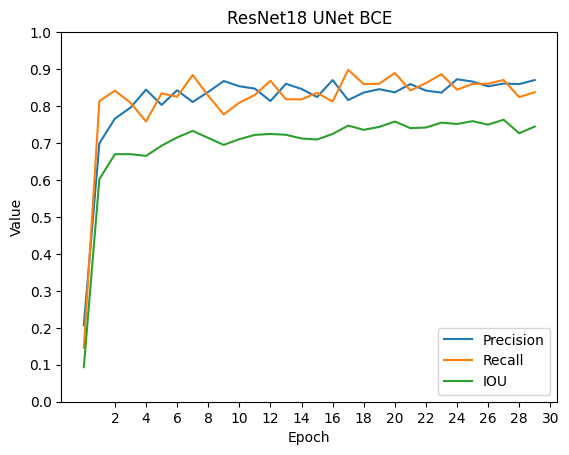

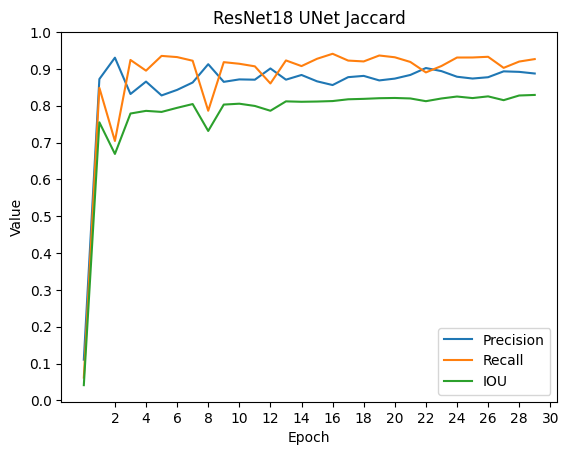

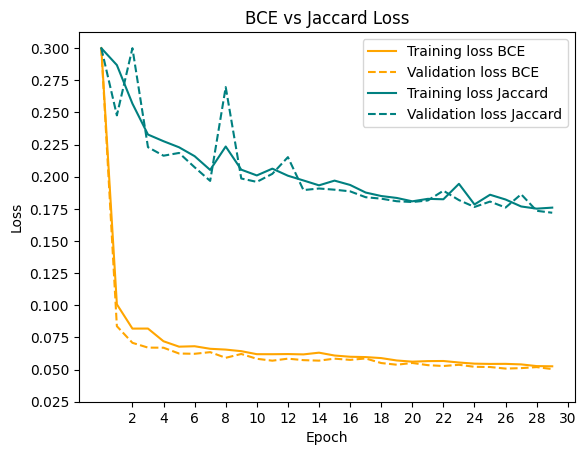

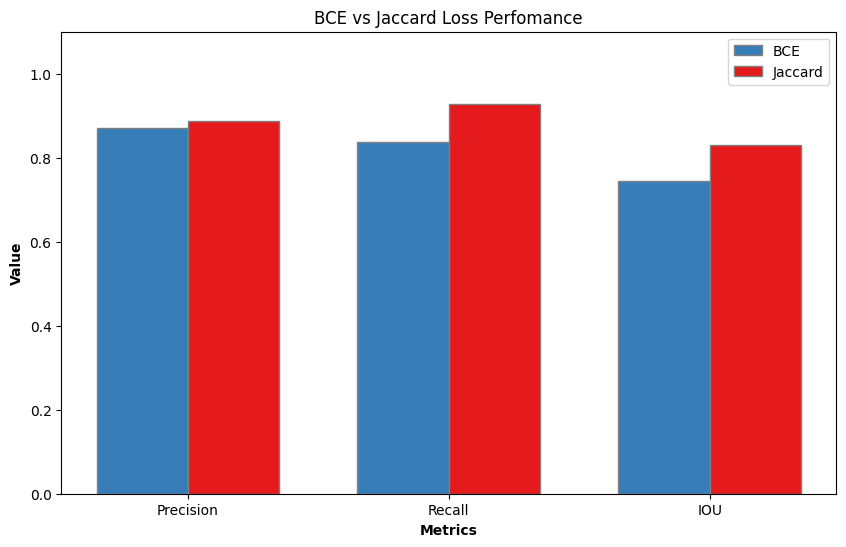

In [17]:
plot_metrics("ResNet18 UNet BCE", sat_resnet18_metrics_BCE)
plot_metrics("ResNet18 UNet Jaccard", sat_resnet18_metrics_jaccard)
plot_loss_comparison("BCE vs Jaccard Loss", sat_resnet18_train_BCE, sat_resnet18_train_jaccard, sat_resnet18_valid_BCE, sat_resnet18_valid_jaccard, compare1='BCE', compare2='Jaccard')
plot_comparison_metrics("BCE vs Jaccard Loss Perfomance", sat_resnet18_metrics_BCE, sat_resnet18_metrics_jaccard, compare1='BCE', compare2='Jaccard')

Jaccard outperforms Binary Cross Entropy by all metrics even though BCE loss is much lower. This indicates that BCE loss is not as relevant to our desired model performance. 

We have a class imbalance, so we need to weight the classes differently or else the model will always predict majority class. Jaccard does that by emphasizing the IOU.

### Imagenet ResNet18

In [18]:
# U-Net model that uses a ResNet18 backbone from SSL4EO-12. 
# The ResNet is pretrained on ImageNet 3-channel RGB images
loss = JaccardLoss()

imagenet_resnet18 = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).to(DEVICE)
imagenet_resnet18_unet = ResNet18_UNet(ResNet18=imagenet_resnet18, input_image_size=INPUT_IMAGE_SIZE).to(DEVICE)
imagenet_resnet18_train, imagenet_resnet18_metrics = train(imagenet_resnet18_unet, trainLoader, testLoader, loss)
imagenet_resnet18_valid = [x['Loss'] for x in imagenet_resnet18_metrics]

[INFO] training the network...


  3%|▎         | 1/30 [00:02<01:18,  2.71s/it]

EPOCH: 1/30
Train loss: 0.731907, Test loss: 0.9156

Validation Metrics:
Precision: 0.10732219177161548
Recall: 0.27523872969376506
f1_score: 0.15442886125441962
IOU: 0.08367537723817228
Accuracy: 0.6767066477845803
Specificity: 0.7249415202300088




 17%|█▋        | 5/30 [00:13<01:11,  2.86s/it]

EPOCH: 5/30
Train loss: 0.235552, Test loss: 0.2254

Validation Metrics:
Precision: 0.8539230785114262
Recall: 0.8950342108979443
f1_score: 0.8739954638927991
IOU: 0.7761917788665025
Accuracy: 0.9723189739832214
Specificity: 0.9816044498897487




 33%|███▎      | 10/30 [00:31<01:07,  3.39s/it]

EPOCH: 10/30
Train loss: 0.213815, Test loss: 0.2139

Validation Metrics:
Precision: 0.8757992577779226
Recall: 0.8877375841167704
f1_score: 0.8817280124817032
IOU: 0.7884736650145917
Accuracy: 0.9744555000506536
Specificity: 0.9848743339488918




 50%|█████     | 15/30 [00:49<00:53,  3.57s/it]

EPOCH: 15/30
Train loss: 0.204296, Test loss: 0.1944

Validation Metrics:
Precision: 0.8834803532424023
Recall: 0.9033031985623284
f1_score: 0.8932818170894524
IOU: 0.8071447915857125
Accuracy: 0.9768501054918345
Specificity: 0.9856864917837141




 67%|██████▋   | 20/30 [01:05<00:33,  3.40s/it]

EPOCH: 20/30
Train loss: 0.185533, Test loss: 0.1856

Validation Metrics:
Precision: 0.8770793033149967
Recall: 0.9211141854561667
f1_score: 0.8985575724729664
IOU: 0.815800762723853
Accuracy: 0.9776924052073941
Specificity: 0.984490067283327




 83%|████████▎ | 25/30 [01:24<00:18,  3.62s/it]

EPOCH: 25/30
Train loss: 0.184127, Test loss: 0.1820

Validation Metrics:
Precision: 0.8817916528969714
Recall: 0.9207181576564695
f1_score: 0.900834582246044
IOU: 0.8195623403862334
Accuracy: 0.9782576022730453
Specificity: 0.9851707515830969




100%|██████████| 30/30 [01:42<00:00,  3.42s/it]

EPOCH: 30/30
Train loss: 0.173782, Test loss: 0.1796

Validation Metrics:
Precision: 0.892487632654069
Recall: 0.9129031384873779
f1_score: 0.9025799554696362
IOU: 0.8224562326596571
Accuracy: 0.9788625359918693
Specificity: 0.9867873113812672




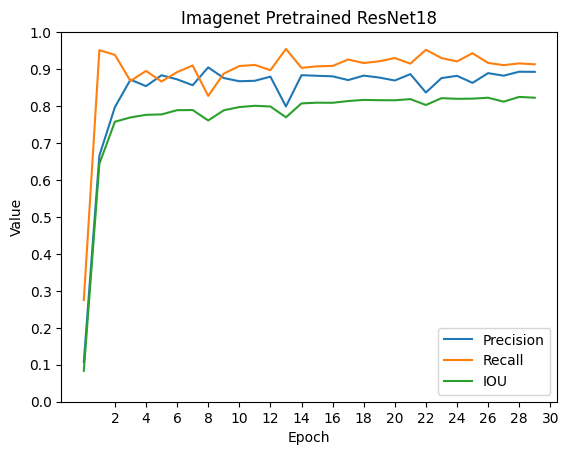

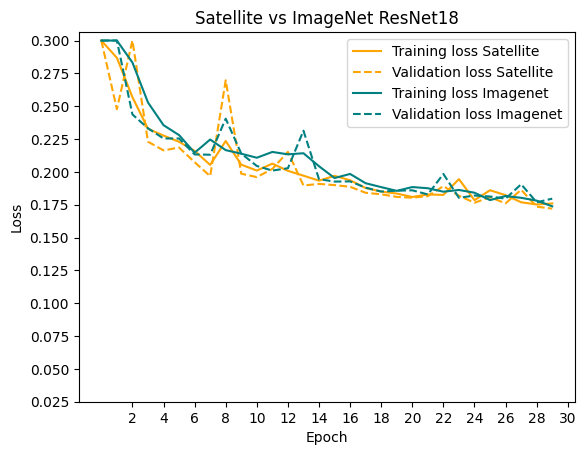

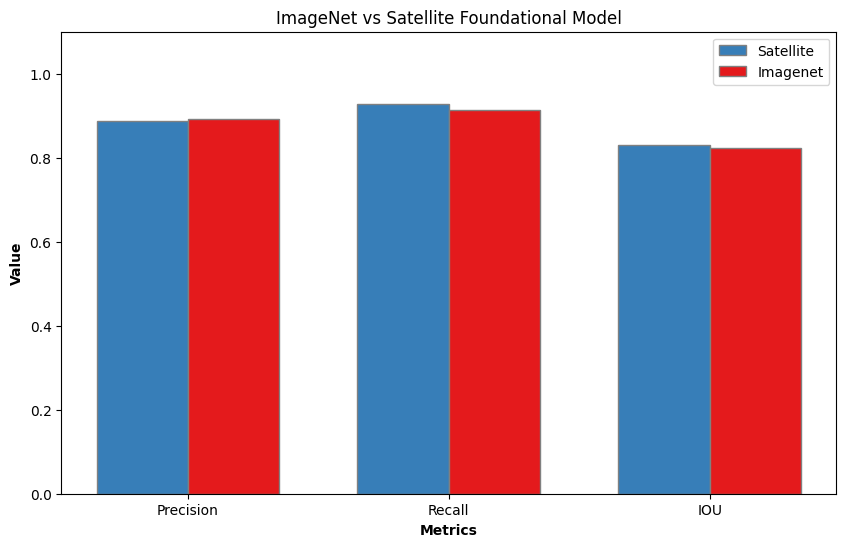

In [20]:
#1:49
plot_metrics("Imagenet Pretrained ResNet18", imagenet_resnet18_metrics)
plot_loss_comparison("Satellite vs ImageNet ResNet18", sat_resnet18_train_jaccard, imagenet_resnet18_train, sat_resnet18_valid_jaccard, imagenet_resnet18_valid, compare1='Satellite', compare2='Imagenet')
plot_comparison_metrics("ImageNet vs Satellite Foundational Model", sat_resnet18_metrics_jaccard, imagenet_resnet18_metrics, compare1='Satellite', compare2='Imagenet')

Imagenet performs slightly worse than the satellite foundational model when the rest of the network the same. The difference is negligible, though. I don't think there is much benefit to using a satellite foundational model based on this.

In [28]:
# Apply activation to classification head and save the model
sat_resnet18_UNet_jaccard.classification_head.append(nn.Sigmoid())
torch.save(sat_resnet18_UNet_jaccard.state_dict(), 'models/satellite_resnet18_jaccard.pth')

### Satellite ResNet50

In [21]:
# U-Net model that uses a ResNet50 backbone from SSL4EO-12. 
# The ResNet is pretrained on Sentinel-2 3-channel RGB satellite imagery
loss = JaccardLoss()
sat_resnet50 = ResNet50_UNet(input_image_size=INPUT_IMAGE_SIZE).to(DEVICE)
sat_resnet50_train, sat_resnet50_metrics = train(sat_resnet50, trainLoader, testLoader,loss)
sat_resnet50_valid = [x['Loss'] for x in sat_resnet50_metrics]

[INFO] training the network...


  3%|▎         | 1/30 [00:21<10:15, 21.23s/it]

EPOCH: 1/30
Train loss: 0.592326, Test loss: 0.9596

Validation Metrics:
Precision: 0.14724369169680881
Recall: 0.052326983405769634
f1_score: 0.07721393143619855
IOU: 0.040157317914141344
Accuracy: 0.8658481687087959
Specificity: 0.9635897026602768




 17%|█▋        | 5/30 [01:54<09:47, 23.48s/it]

EPOCH: 5/30
Train loss: 0.222144, Test loss: 0.2094

Validation Metrics:
Precision: 0.8586196534834102
Recall: 0.911229357320959
f1_score: 0.8841425796783013
IOU: 0.7923436843959916
Accuracy: 0.9743849750019021
Specificity: 0.9819728865434911




 33%|███▎      | 10/30 [04:16<09:52, 29.64s/it]

EPOCH: 10/30
Train loss: 0.203223, Test loss: 0.2719

Validation Metrics:
Precision: 0.7693991271495251
Recall: 0.9363259572970966
f1_score: 0.8446945886423983
IOU: 0.7311439731332999
Accuracy: 0.9630699840928588
Specificity: 0.9662831791909446




 50%|█████     | 15/30 [07:50<09:24, 37.63s/it]

EPOCH: 15/30
Train loss: 0.189637, Test loss: 0.1811

Validation Metrics:
Precision: 0.8803497523825629
Recall: 0.9233027730823343
f1_score: 0.9013148111193504
IOU: 0.8203576604483201
Accuracy: 0.9783137156487429
Specificity: 0.9849230750036947




 67%|██████▋   | 20/30 [10:28<05:24, 32.43s/it]

EPOCH: 20/30
Train loss: 0.180906, Test loss: 0.1852

Validation Metrics:
Precision: 0.851969118234623
Recall: 0.9514023994523783
f1_score: 0.8989445107654535
IOU: 0.8164388802878585
Accuracy: 0.9770566509108544
Specificity: 0.9801389134974496




 83%|████████▎ | 25/30 [13:06<02:39, 31.81s/it]

EPOCH: 25/30
Train loss: 0.173119, Test loss: 0.1667

Validation Metrics:
Precision: 0.888151509103382
Recall: 0.9329178439839897
f1_score: 0.9099844435898323
IOU: 0.834836198656425
Accuracy: 0.9802033126123502
Specificity: 0.9858844848801613




100%|██████████| 30/30 [16:07<00:00, 32.26s/it]

EPOCH: 30/30
Train loss: 0.167553, Test loss: 0.1600

Validation Metrics:
Precision: 0.8942131236967037
Recall: 0.9346612203526264
f1_score: 0.9139898891021367
IOU: 0.8416034804192495
Accuracy: 0.9811319128456422
Specificity: 0.9867151929601969




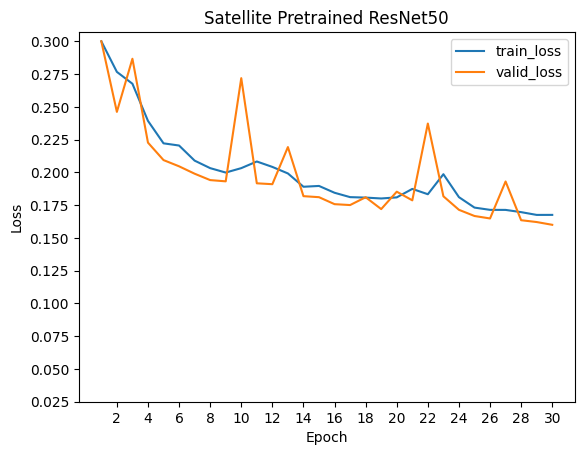

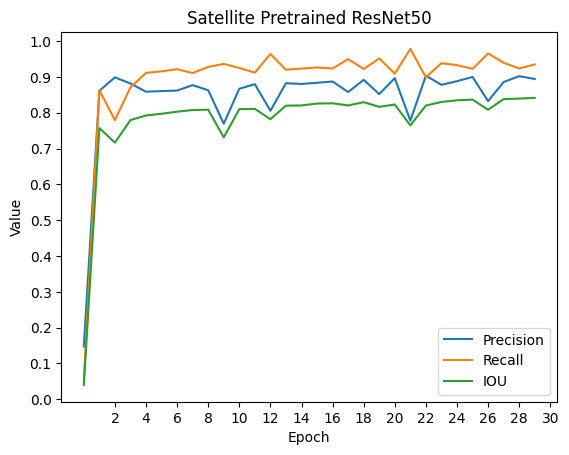

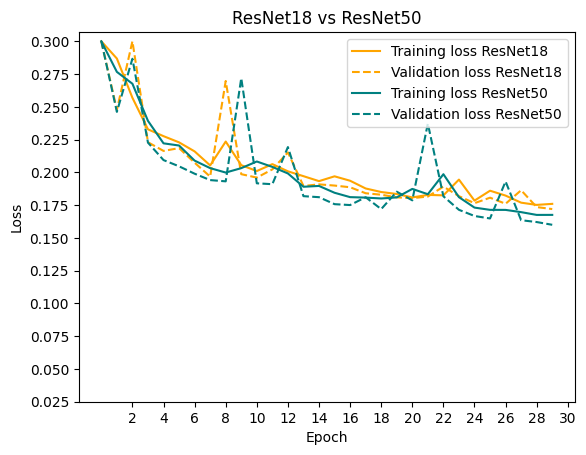

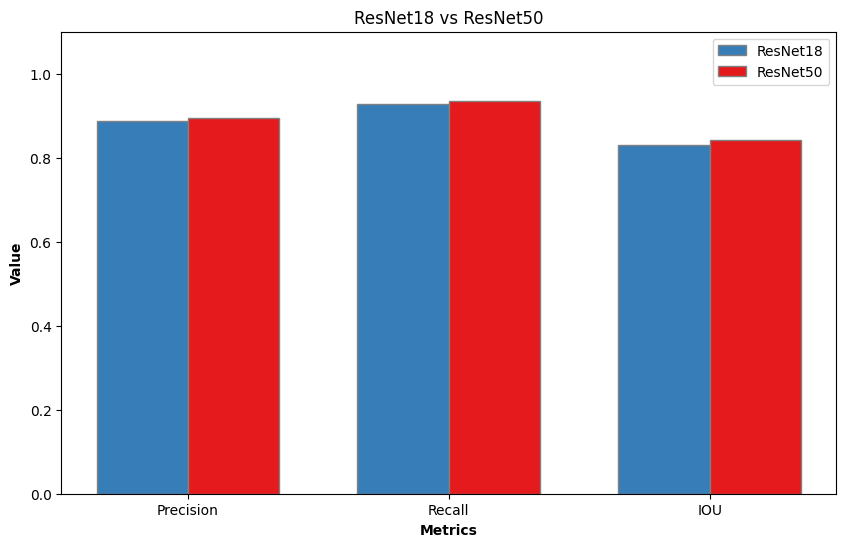

In [24]:
plot_losses("Satellite Pretrained ResNet50", sat_resnet50_train, sat_resnet50_valid)
plot_metrics("Satellite Pretrained ResNet50", sat_resnet50_metrics)
plot_loss_comparison("ResNet18 vs ResNet50", sat_resnet18_train_jaccard, sat_resnet50_train, sat_resnet18_valid_jaccard, sat_resnet50_valid, compare1='ResNet18', compare2='ResNet50')
plot_comparison_metrics("ResNet18 vs ResNet50", sat_resnet18_metrics_jaccard, sat_resnet50_metrics, compare1='ResNet18', compare2='ResNet50')

Better than smaller ResNet, but it takes about 10x longer to train. It does not seem to have fully converged either. From the way I built the decoder, I have a feeling it would perform better on larger sized images.

### ImageNet ResNet50

In [ ]:
imagenet_resnet50 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
imagenet_resnet50_unet = ResNet50_UNet(ResNet50=imagenet_resnet50, input_image_size=128).to(DEVICE)
imagenet_resnet50_train, imagenet_resnet50_metrics = train(imagenet_resnet50_unet, trainLoader, testLoader, loss)
imagenet_resnet50_valid = [x['Loss'] for x in imagenet_resnet50_metrics]

In [ ]:
plot_losses("Imagenet Pretrained ResNet50", imagenet_resnet50_train, imagenet_resnet50_valid)
plot_metrics("Imagenet ResNet50", imagenet_resnet50_metrics)

In [ ]:
plot_comparison_metrics("ResNet50 Comparison", imagenet_resnet50_metrics, sat_resnet50_metrics)

### Shifted Window Transformer

In [ ]:
# U-Net model that uses a Swin Transformer backbone from Satlas.
# The Swin Transformer is pretrained on high-resolution drone imagery.
# Training is unstable and the model does not converge. Need to change decoder.

weight = torch.tensor([2.0]).to(DEVICE)
loss = BCETverskyLoss(alpha=0.3, beta=0.9, pos_weight=weight)
swin_satlas = SwinB_UNet().to(DEVICE)
train_swin, swin_metrics = train(swin_satlas, trainLoader, testLoader, loss, print_all_epochs=True)
valid_swin = [x['Loss'] for x in swin_metrics]

/Users/gage/anaconda3/envs/mangrove/lib/python3.10/site-packages/satlaspretrain_models/model.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(weight

[INFO] training the network...


  3%|▎         | 1/30 [01:06<32:08, 66.49s/it]

EPOCH: 1/30
Train loss: 6.235936, Test loss: 1.3568

Validation Metrics:
Precision: 0.13077515473284498
Recall: 0.21164991620316875
f1_score: 0.16166193944271764
IOU: 0.08793917882204466
Accuracy: 0.7645519754628468
Specificity: 0.8309810955797777




  7%|▋         | 2/30 [02:08<29:51, 63.98s/it]

EPOCH: 2/30
Train loss: 1.341414, Test loss: 1.5072

Validation Metrics:
Precision: 0.1820301603366979
Recall: 0.9051226835741765
f1_score: 0.30310296870988407
IOU: 0.17862189815927787
Accuracy: 0.5535720051038727
Specificity: 0.511334502776488




 10%|█         | 3/30 [03:12<28:44, 63.86s/it]

EPOCH: 3/30
Train loss: 0.866058, Test loss: 0.6526

Validation Metrics:
Precision: 0.45531659834426913
Recall: 0.8717223017303687
f1_score: 0.5981883923709912
IOU: 0.42672523833837633
Accuracy: 0.8743888458203638
Specificity: 0.874709221147406




 13%|█▎        | 4/30 [04:26<29:26, 67.95s/it]

EPOCH: 4/30
Train loss: 0.771010, Test loss: 1.3970

Validation Metrics:
Precision: 0.6772102523362041
Recall: 0.2707487235023366
f1_score: 0.3868391270846554
IOU: 0.23980195253902364
Accuracy: 0.9079389350791524
Specificity: 0.984494959574065




 17%|█▋        | 5/30 [06:19<35:02, 84.09s/it]

EPOCH: 5/30
Train loss: 0.644087, Test loss: 0.5259

Validation Metrics:
Precision: 0.6971379412121909
Recall: 0.7637748210461908
f1_score: 0.7289366210624957
IOU: 0.5734856602286991
Accuracy: 0.9390726961379193
Specificity: 0.9601340816248816




 20%|██        | 6/30 [08:11<37:26, 93.60s/it]

EPOCH: 6/30
Train loss: 0.509093, Test loss: 0.3587

Validation Metrics:
Precision: 0.7111448924168146
Recall: 0.8610999869483462
f1_score: 0.7789713493304719
IOU: 0.6379632033231468
Accuracy: 0.9475861318371445
Specificity: 0.9579771192945901




 23%|██▎       | 7/30 [09:47<36:09, 94.32s/it]

EPOCH: 7/30
Train loss: 0.380103, Test loss: 0.3069

Validation Metrics:
Precision: 0.7508014403444705
Recall: 0.8932293324477526
f1_score: 0.8158458837369457
IOU: 0.6889693432064289
Accuracy: 0.956748436213967
Specificity: 0.9643800192671742




 27%|██▋       | 8/30 [11:18<34:13, 93.32s/it]

EPOCH: 8/30
Train loss: 0.385751, Test loss: 0.3983

Validation Metrics:
Precision: 0.630056008507242
Recall: 0.9630747071981186
f1_score: 0.7617592202945755
IOU: 0.6151947446568486
Accuracy: 0.9353864047056168
Specificity: 0.9320597584676122




 30%|███       | 9/30 [12:49<32:24, 92.62s/it]

EPOCH: 9/30
Train loss: 0.299782, Test loss: 0.2773

Validation Metrics:
Precision: 0.7450078461894357
Recall: 0.9404653939317771
f1_score: 0.8314034075063976
IOU: 0.7114545882187733
Accuracy: 0.9590885045392407
Specificity: 0.9613260017651505




 33%|███▎      | 10/30 [14:23<30:58, 92.91s/it]

EPOCH: 10/30
Train loss: 0.274142, Test loss: 0.2448

Validation Metrics:
Precision: 0.7932058708644384
Recall: 0.9167878206089707
f1_score: 0.8505311864834529
IOU: 0.7399341125936595
Accuracy: 0.965438330038968
Specificity: 0.9712835070985153




 37%|███▋      | 11/30 [16:02<30:02, 94.88s/it]

EPOCH: 11/30
Train loss: 0.278764, Test loss: 0.2667

Validation Metrics:
Precision: 0.7802517792475147
Recall: 0.9042845961860372
f1_score: 0.8377019047020368
IOU: 0.7207289662530901
Accuracy: 0.9624167275940726
Specificity: 0.969401086125459




 40%|████      | 12/30 [17:42<28:55, 96.42s/it]

EPOCH: 12/30
Train loss: 0.251931, Test loss: 0.2219

Validation Metrics:
Precision: 0.7917900682464796
Recall: 0.9350341331130544
f1_score: 0.8574708872941353
IOU: 0.7505024403827903
Accuracy: 0.96665910869747
Specificity: 0.9704587314743207




 43%|████▎     | 13/30 [19:17<27:13, 96.11s/it]

EPOCH: 13/30
Train loss: 0.236606, Test loss: 0.2129

Validation Metrics:
Precision: 0.7998543143200012
Recall: 0.9386507118200162
f1_score: 0.8637119941559637
IOU: 0.7601171443452818
Accuracy: 0.9682269985819241
Specificity: 0.9717804790324556




 47%|████▋     | 14/30 [20:49<25:16, 94.80s/it]

EPOCH: 14/30
Train loss: 0.218902, Test loss: 0.2054

Validation Metrics:
Precision: 0.8237885324703702
Recall: 0.9347022891888682
f1_score: 0.8757475644724222
IOU: 0.7789598997501485
Accuracy: 0.9715511425763848
Specificity: 0.9759783948559021




 50%|█████     | 15/30 [22:16<23:07, 92.48s/it]

EPOCH: 15/30
Train loss: 0.214874, Test loss: 0.1992

Validation Metrics:
Precision: 0.8171213194987346
Recall: 0.9424254712441326
f1_score: 0.8753116980391322
IOU: 0.7782704741509685
Accuracy: 0.9712011236926132
Specificity: 0.974658410983113




 53%|█████▎    | 16/30 [23:42<21:05, 90.42s/it]

EPOCH: 16/30
Train loss: 0.482621, Test loss: 0.3458

Validation Metrics:
Precision: 0.8043354636988599
Recall: 0.8591370052450789
f1_score: 0.8308335417578097
IOU: 0.7106204047342797
Accuracy: 0.9624743510356618
Specificity: 0.9748899476632287




 57%|█████▋    | 17/30 [25:05<19:06, 88.16s/it]

EPOCH: 17/30
Train loss: 0.305762, Test loss: 0.2353

Validation Metrics:
Precision: 0.8105338710272939
Recall: 0.9145550018927038
f1_score: 0.8594082514679169
IOU: 0.7534757748107126
Accuracy: 0.9679051257033928
Specificity: 0.9743149438446057




 60%|██████    | 18/30 [26:30<17:26, 87.20s/it]

EPOCH: 18/30
Train loss: 2.628485, Test loss: 2.9922

Validation Metrics:
Precision: 0.6387481981099599
Recall: 0.46302223846530977
f1_score: 0.5368715853801214
IOU: 0.36693401619132715
Accuracy: 0.9143162628613516
Specificity: 0.9685375552402165




 63%|██████▎   | 19/30 [27:54<15:48, 86.27s/it]

EPOCH: 19/30
Train loss: 13.401415, Test loss: 1.5688

Validation Metrics:
Precision: 0.11741726172865256
Recall: 0.6043292043631723
f1_score: 0.19663048921655873
IOU: 0.10903505246195282
Accuracy: 0.4703321482264133
Specificity: 0.454232901939366




 67%|██████▋   | 20/30 [29:18<14:15, 85.56s/it]

EPOCH: 20/30
Train loss: 1.381630, Test loss: 0.9703

Validation Metrics:
Precision: 0.30391028663194763
Recall: 0.5036605648810812
f1_score: 0.3790816034319152
IOU: 0.2338684070922582
Accuracy: 0.8230276951160923
Specificity: 0.8613984635332512




 70%|███████   | 21/30 [30:40<12:42, 84.75s/it]

EPOCH: 21/30
Train loss: 0.933501, Test loss: 0.7845

Validation Metrics:
Precision: 0.5414515137187249
Recall: 0.6774964883949289
f1_score: 0.6018821123533893
IOU: 0.4304945367421845
Accuracy: 0.9038669196581909
Specificity: 0.9310644829077772




 73%|███████▎  | 22/30 [32:03<11:13, 84.22s/it]

EPOCH: 22/30
Train loss: 0.785747, Test loss: 0.7142

Validation Metrics:
Precision: 0.44210470382239253
Recall: 0.7944640671477391
f1_score: 0.568082114556924
IOU: 0.3967281366704512
Accuracy: 0.870422418150775
Specificity: 0.8795485304298548




 77%|███████▋  | 23/30 [33:29<09:52, 84.65s/it]

EPOCH: 23/30
Train loss: 0.735039, Test loss: 0.6689

Validation Metrics:
Precision: 0.49260258381708344
Recall: 0.7796163452121077
f1_score: 0.6037341801392168
IOU: 0.4323920069886212
Accuracy: 0.890229072429737
Specificity: 0.9035187789314649




 80%|████████  | 24/30 [35:00<08:39, 86.59s/it]

EPOCH: 24/30
Train loss: 0.704157, Test loss: 0.6496

Validation Metrics:
Precision: 0.4763724260607559
Recall: 0.808336687476473
f1_score: 0.5994653650846447
IOU: 0.42802609099408284
Accuracy: 0.8841399217586339
Specificity: 0.8932473975188149




 83%|████████▎ | 25/30 [36:41<07:33, 90.75s/it]

EPOCH: 25/30
Train loss: 0.685854, Test loss: 0.6355

Validation Metrics:
Precision: 0.47582194056010096
Recall: 0.8158304565461805
f1_score: 0.6010750754173612
IOU: 0.4296692873612845
Accuracy: 0.8838476731132826
Specificity: 0.8920196879171253




 87%|████████▋ | 26/30 [38:15<06:07, 91.87s/it]

EPOCH: 26/30
Train loss: 0.669450, Test loss: 0.6256

Validation Metrics:
Precision: 0.5380600577478772
Recall: 0.7713716026084054
f1_score: 0.6339303708780374
IOU: 0.46405421609840947
Accuracy: 0.9044454576151255
Specificity: 0.9204337848809303




 90%|█████████ | 27/30 [39:49<04:37, 92.50s/it]

EPOCH: 27/30
Train loss: 0.653480, Test loss: 0.6164

Validation Metrics:
Precision: 0.4934537476606223
Recall: 0.8063805085768577
f1_score: 0.6122495727255713
IOU: 0.44118132532521903
Accuracy: 0.8904457169108726
Specificity: 0.9005458379761455




 90%|█████████ | 27/30 [40:16<04:28, 89.49s/it]


KeyboardInterrupt: 

In [ ]:
plot_losses("Satlas high-res Swin", train_swin, valid_swin)
plot_metrics("Satlas high-res Swin", swin_metrics)